In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime, timedelta
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import random
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from scipy.stats import norm
from sklearn.preprocessing import Normalizer,StandardScaler, LabelEncoder
from tensorflow_addons.losses import pinball_loss
from sklearn.metrics import mean_pinball_loss
from scipy import stats
import math
from tensorflow_addons.utils.types import TensorLike, FloatTensorLike

In [2]:
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
horizons = [36, 48 ,60, 72, 84]

# Prepare data

In [3]:
data = pd.read_feather("data/berlin_data/historic_data/icon_eps_t_2m.feather")

data.dropna(inplace=True)
data.head()

,init_tm,met_var,location,fcst_hour,obs_tm,obs,ens_1,ens_2,ens_3,ens_4,...,ens_33,ens_34,ens_35,ens_36,ens_37,ens_38,ens_39,ens_40,ens_mean,ens_var
0,2018-12-13 00:00:00+00:00,t_2m,Berlin,0.0,2018-12-13 00:00:00+00:00,2.3,0.05,0.03,0.32,0.61,...,0.30,-0.03,0.44,0.42,0.05,0.47,0.51,0.74,0.34500,0.148036
1,2018-12-13 00:00:00+00:00,t_2m,Berlin,1.0,2018-12-13 01:00:00+00:00,2.3,0.06,0.00,0.34,0.51,...,0.13,0.05,0.39,0.38,0.04,0.38,0.33,0.60,0.30125,0.162580
2,2018-12-13 00:00:00+00:00,t_2m,Berlin,2.0,2018-12-13 02:00:00+00:00,2.2,0.10,0.11,0.40,0.45,...,0.08,0.15,0.57,0.37,0.08,0.42,0.31,0.57,0.32525,0.171626
3,2018-12-13 00:00:00+00:00,t_2m,Berlin,3.0,2018-12-13 03:00:00+00:00,2.2,0.12,0.32,0.48,0.42,...,0.05,0.19,0.68,0.32,0.08,0.28,0.35,0.60,0.31700,0.161878
4,2018-12-13 00:00:00+00:00,t_2m,Berlin,4.0,2018-12-13 04:00:00+00:00,2.1,0.11,0.57,0.54,0.35,...,0.03,0.17,0.76,0.30,0.10,0.11,0.34,0.56,0.29275,0.150544


## Calculate positional encoding for day of year

In [4]:
pos_enc = pd.DataFrame(index=pd.DatetimeIndex(data["obs_tm"]))
pos_enc["Dayofyear"] = pos_enc.index.dayofyear
pos_enc["n_days"] = 365
pos_enc.loc[pos_enc.index.year==2020,"n_days"] = 366
#Calculate actual positional encoding
cos_encoding = np.cos(2*math.pi*pos_enc["Dayofyear"]/pos_enc["n_days"])
data["pos_enc_1"] = cos_encoding.to_numpy()

## Train, val, test split

In [5]:
train_val_dataframe, test_dataframe = train_test_split(data, test_size = 0.2)#, random_state = 1)
train_dataframe, val_dataframe = train_test_split(data, test_size = 0.2)#, random_state = 2)

## Normalize and change format

In [6]:
def normalize(dataframe, label_encoder = None,feature_scaler = None, target_scaler = None, learn = False):
    #Drop unused columns
    data = dataframe.copy()
    data.drop(["init_tm", "met_var", "location", "ens_var", "obs_tm"], axis = 1, inplace = True)
    data = data.to_numpy()
    if learn == True:
        label_encoder = LabelEncoder()
        feature_scaler = StandardScaler()
        target_scaler = StandardScaler()
        #Learn label encoding for horizons
        label = label_encoder.fit_transform(data[:,0])
        #Learn target scaling
        target_scaled = target_scaler.fit_transform(data[:,1].reshape(-1,1))
        #Learn feature scaling
        features_scaled = feature_scaler.fit_transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = features_scaled
        
        return data, label_encoder, feature_scaler, target_scaler
    
    else:
        #Learn labels
        label = label_encoder.transform(data[:,0])
        #Scale target
        target_scaled = target_scaler.transform(data[:,1].reshape(-1,1))
        #Scale features
        features_scaled = feature_scaler.transform(data[:,2:])
        #Append
        data[:,0] = label
        data[:,1] = target_scaled.reshape(-1)
        data[:,2:] = features_scaled
        
        return data

In [7]:
train_val, label_encoder, feature_scaler, target_scaler = normalize(train_val_dataframe, learn = True)
train= normalize(train_dataframe, label_encoder, feature_scaler, target_scaler)
test = normalize(test_dataframe, label_encoder, feature_scaler, target_scaler)
val = normalize(val_dataframe, label_encoder, feature_scaler, target_scaler)
#Number of encodings
n_encodings = len(np.unique(train[:,0]))

In [8]:
def convert_format(input_data, predict = False):
    #Extract forecast embedding
    horizon_emb = input_data[:,0]
    
    if predict == False:        
        #Extract features
        features = input_data[:,2:]
        # Extract target
        target = np.expand_dims(input_data[:,1],1)
        return [features, horizon_emb], target
    else:
        #Extract features
        features = input_data[:,1:]
        return [features, horizon_emb]

In [9]:
train_data, train_target = convert_format(train)
val_data, val_target = convert_format(val)
test_data, test_target = convert_format(test)

# Build model

## Obtain optimal parameters

In [10]:
params = {'alpha': 0.003228856882727001,
 'batch_size': 7,
 'dropout': 0.05,
 'learning_rate': 0.0005,
 'loss': 'huber',
 'n_layers': 2,
 'n_units_1': 64,
 'n_units_2': 60}

## Loss function

In [11]:
#Huber quantile loss

@tf.function
def huber_pinball_loss(
    y_true: TensorLike, y_pred: TensorLike, tau: FloatTensorLike = 0.5,
    alpha: FloatTensorLike = params["alpha"]
) -> tf.Tensor:
    """Computes the pinball loss between `y_true` and `y_pred`.
    `loss = maximum(tau * (y_true - y_pred), (tau - 1) * (y_true - y_pred))`
    In the context of regression this loss yields an estimator of the tau
    conditional quantile.
    See: https://en.wikipedia.org/wiki/Quantile_regression
    Usage:
    >>> loss = tfa.losses.pinball_loss([0., 0., 1., 1.],
    ... [1., 1., 1., 0.], tau=.1)
    >>> loss
    <tf.Tensor: shape=(), dtype=float32, numpy=0.475>
    Args:
      y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`
      y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`
      tau: (Optional) Float in [0, 1] or a tensor taking values in [0, 1] and
        shape = `[d0,..., dn]`.  It defines the slope of the pinball loss. In
        the context of quantile regression, the value of tau determines the
        conditional quantile level. When tau = 0.5, this amounts to l1
        regression, an estimator of the conditional median (0.5 quantile).
    Returns:
        pinball_loss: 1-D float `Tensor` with shape [batch_size].
    References:
      - https://en.wikipedia.org/wiki/Quantile_regression
      - https://projecteuclid.org/download/pdfview_1/euclid.bj/1297173840
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    # Broadcast the pinball slope along the batch dimension
    tau = tf.expand_dims(tf.cast(tau, y_pred.dtype), 0)
    alpha = tf.expand_dims(tf.cast(alpha, y_pred.dtype), 0)
    one = tf.cast(1, tau.dtype)

    error = tf.subtract(y_true,y_pred)
    abs_error = tf.abs(error)
    half = tf.convert_to_tensor(0.5, dtype=abs_error.dtype)
    huber = tf.where(abs_error <= alpha, half * tf.square(error)/alpha,
                         abs_error - half * alpha)
    
    
    #Implement smooth loss
    pinball = tf.where(error >=0, tau * huber, (one - tau) * huber)
    return tf.reduce_mean(pinball, axis=-1)

In [12]:
BATCH_SIZE = 2**params["batch_size"]
EPOCHS = 100
learning_rate = params["learning_rate"]

In [13]:
class base_model(tf.keras.Model):    
    def __init__(self, n_embeddings = n_encodings):
        super(base_model, self).__init__()
        #Embedding layers
        self.embedding = Embedding(input_dim = n_embeddings, output_dim = 4)
        #Create Dense layers
        self.hidden = Dense(params["n_units_1"], activation = "relu")
        self.hidden2 = Dense(params["n_units_2"], activation = "relu")
        self.out = Dense(5, activation = "linear")
        #Create Dropout
        self.dropout = Dropout(rate = params["dropout"])

    def call(self, input_data):
        #Extract data
        features, horizon_emb = input_data
        #Calculate embedding
        emb = self.embedding(horizon_emb)
        emb = tf.squeeze(emb, axis = 1)
        conc = Concatenate(axis = 1)([features, emb])
        #Calculate output
        output = self.hidden(conc)
        output = self.hidden2(output)
        output = self.dropout(output)
        output = self.out(output)

        return output

In [14]:
def train_model(train_data, train_target, validation_data, batch_size, epochs, learning_rate, fine_tuning = True):
    model = base_model()    
    #Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    #Callbacks
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 7, min_delta = 1e-5)
    model.compile(optimizer = optimizer, loss = lambda true,pred: huber_pinball_loss(true, pred, tau = quantiles))
    #Normal fit
    history1 = model.fit(x = train_data, y = train_target, validation_data = validation_data, epochs = epochs, batch_size = BATCH_SIZE, callbacks = [callback], shuffle = True, verbose = False)
    
    #Fine tuning
    if fine_tuning == True:
        enc_horizons = label_encoder.transform(horizons)
        train_filtering = np.isin(train_data[1], enc_horizons)
        train_data_fine = [train_data[0][train_filtering], train_data[1][train_filtering]]
        train_target_fine = train_target[train_filtering]
        #Val filtering
        val_data, val_target = validation_data
        val_filtering = np.isin(val_data[1], enc_horizons)
        val_data_fine = [val_data[0][val_filtering], val_data[1][val_filtering]]
        val_target_fine = val_target[val_filtering]
        validation_data_fine = (val_data_fine, val_target_fine)
        
        #New optimizer
        history2 = model.fit(x = train_data_fine, y = train_target_fine, validation_data = validation_data_fine, epochs = epochs, batch_size = 256, callbacks = [callback], shuffle = True, verbose = False)
    return model, [history1, history2]

In [15]:
def aggregate_training(train_data, train_target, validation_data, test_data,  BATCH_SIZE, EPOCHS, learning_rate, n = 10):
    predictions = np.zeros(shape = (len(test_data[0]),5))
    for i in range(n):
        model,_ = train_model(train_data, train_target, validation_data, BATCH_SIZE, EPOCHS, learning_rate)
        pred = model.predict(test_data)
        predictions += pred
        print("Finished Training {}".format(i+1))
    predictions = predictions/n
    return predictions

In [16]:
predictions = aggregate_training(train_data, train_target, (val_data,val_target), test_data, BATCH_SIZE, EPOCHS, learning_rate, n = 10)

Finished Training 1
Finished Training 2
Finished Training 3
Finished Training 4
Finished Training 5
Finished Training 6
Finished Training 7
Finished Training 8
Finished Training 9
Finished Training 10


## Pinball Loss

### All horizons

In [17]:
total_loss = 0
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(test_target.reshape(-1), predictions[:,cnt].reshape(-1), alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.009222471894295434
Pinball loss for quantile 0.25 : 	 0.04399586411289249
Pinball loss for quantile 0.5 : 	 0.05310910633639317
Pinball loss for quantile 0.75 : 	 0.042451155637874466
Pinball loss for quantile 0.975 : 	 0.008322837262100426
Pinball Loss total: 0.0314202870487112


### Specific horizons

In [18]:
eval_df = test_dataframe[["fcst_hour","obs"]].copy()
eval_df["obs"] = target_scaler.transform(eval_df["obs"].to_numpy().reshape(-1,1))
for cnt,quantile in enumerate(quantiles):
    eval_df[quantile] = predictions[:,cnt]
eval_df = eval_df[eval_df["fcst_hour"].isin(horizons)]

total_loss = 0
for cnt,quantile in enumerate(quantiles):
    loss = mean_pinball_loss(eval_df["obs"], eval_df[quantile], alpha = quantile)
    total_loss += loss
    print("Pinball loss for quantile {} : \t {}".format(quantile,loss))
print("Pinball Loss total: {}".format(total_loss/len(quantiles)))

Pinball loss for quantile 0.025 : 	 0.00970526585323886
Pinball loss for quantile 0.25 : 	 0.04720096002491347
Pinball loss for quantile 0.5 : 	 0.057609886815822645
Pinball loss for quantile 0.75 : 	 0.04596142736337523
Pinball loss for quantile 0.975 : 	 0.009269982070821038
Pinball Loss total: 0.03394950442563425


## Plausability

### All horizons

In [19]:
for cnt,quantile in enumerate(quantiles):
    q_smaller = (predictions[:,cnt] > test_target.flatten()).sum()
    emp_quant = q_smaller / predictions[:,cnt].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 1.79 %
Quantile met for quantile = 0.25: 	 22.41 %
Quantile met for quantile = 0.5: 	 48.9 %
Quantile met for quantile = 0.75: 	 77.56 %
Quantile met for quantile = 0.975: 	 98.42999999999999 %


### Specific horizons

In [20]:
for quantile in quantiles:
    q_smaller = (eval_df[quantile] > eval_df["obs"]).sum()
    emp_quant = q_smaller / eval_df[quantile].size
    print("Quantile met for quantile = {}: \t {} %".format(quantile, np.round(emp_quant,4)*100))

Quantile met for quantile = 0.025: 	 1.41 %
Quantile met for quantile = 0.25: 	 23.44 %
Quantile met for quantile = 0.5: 	 48.089999999999996 %
Quantile met for quantile = 0.75: 	 78.36999999999999 %
Quantile met for quantile = 0.975: 	 98.59 %


### Analyze crossing of quantiles

In [21]:
#Group prediction
perc_wrong_total = np.sum(np.diff(predictions) < 0) / len(predictions) * 100

#Single prediction
model,_ = train_model(train_data, train_target, (val_data, val_target), BATCH_SIZE, EPOCHS, learning_rate)
predictions_single = model.predict(test_data)
#Get amount of wrongly specified quantiles
perc_wrong_single = np.sum(np.diff(predictions_single) < 0) / len(predictions_single) * 100

print("Amount of wrongly specified quantiles in single prediction: {:.4f}%\nAmount of wrongly specified quantiles in aggregated prediction: {}%".format(perc_wrong_single, perc_wrong_total))

Amount of wrongly specified quantiles in single prediction: 0.0077%
Amount of wrongly specified quantiles in aggregated prediction: 0.0%


## Visualize predictions

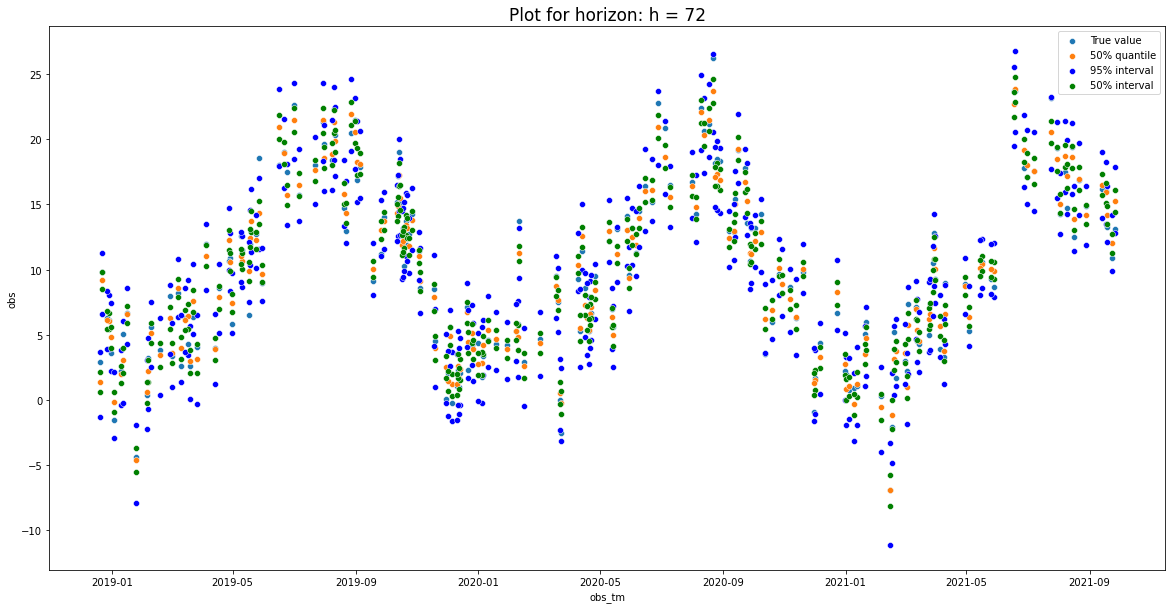

In [22]:
# Create plotting dataframe
data_plot = test_dataframe[["obs_tm","obs","fcst_hour"]].copy()
for cnt, quantile in enumerate(quantiles):
    data_plot["q{}".format(quantile)] = target_scaler.inverse_transform(predictions[:,cnt].reshape(-1,1)).reshape(-1)

#Extract horizon
h=72
data_plot = data_plot[data_plot["fcst_hour"]==h]

fig, axs = plt.subplots(figsize = (20,10))
sns.scatterplot(x = "obs_tm", y = "obs", data = data_plot, label = "True value")
sns.scatterplot(x = "obs_tm", y = "q0.5", data = data_plot, label = "50% quantile")
sns.scatterplot(x = "obs_tm", y = "q0.025", data = data_plot, color = "blue", label = "95% interval")
sns.scatterplot(x = "obs_tm", y = "q0.975", data = data_plot, color = "blue")

sns.scatterplot(x = "obs_tm", y = "q0.25", data = data_plot, color = "green", label = "50% interval")
sns.scatterplot(x = "obs_tm", y = "q0.75", data = data_plot, color = "green")
axs.set_title("Plot for horizon: h = {}".format(h),size = 17)
axs.legend()

# Predict new data

## Train on complete data

In [16]:
train_data, train_target = convert_format(train_val)
val_data, val_target = convert_format(test)

## Predict new data

In [17]:
current_date = date.today().strftime("%Y%m%d")
path = "data/berlin_data/icon_data/icon-eu-eps_{}00_t_2m_Berlin.txt".format(current_date)
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data = new_data[new_data["fcst_hour"].isin(horizons)]
#Create positional encoding
date_list = [(date.today()+timedelta(x)) for x in horizons]
new_data["day"] = pd.DatetimeIndex(date_list).dayofyear
new_data["pos_enc_1"] = np.sin(2*math.pi*new_data["day"]/365)
new_data["pos_enc_2"] = np.cos(2*math.pi*new_data["day"]/365)
new_data.drop("day", axis = 1, inplace = True)
# Normalize and get horizons
new_data = new_data[new_data["fcst_hour"].isin(horizons)].to_numpy()
new_data[:,1:] = feature_scaler.transform(new_data[:,1:])
new_data[:,0] = label_encoder.transform(new_data[:,0])

In [18]:
pred_data = convert_format(new_data, predict = True)

In [19]:
#Prepare dataframe
final_prediction = pd.DataFrame(columns = ["forecast_date","target","horizon","q0.025","q0.25","q0.5","q0.75","q0.975"], index = np.arange(0,5))
final_prediction["forecast_date"] = datetime.today().strftime("%Y-%m-%d")
final_prediction["horizon"] = ["{} hour".format(x) for x in horizons]
final_prediction["target"] = "temperature"

In [20]:
# Predict data
predictions = aggregate_training(train_data, train_target, (val_data,val_target), pred_data, BATCH_SIZE, EPOCHS, learning_rate)

Finished Training 1
Finished Training 2
Finished Training 3
Finished Training 4
Finished Training 5
Finished Training 6
Finished Training 7
Finished Training 8
Finished Training 9
Finished Training 10


In [21]:
for cnt, quantile in enumerate(quantiles):
    #Retransform predictions
    final_pred = target_scaler.inverse_transform(predictions[:,cnt].reshape(-1,1))
    final_prediction.loc[:,"q{}".format(quantile)] = final_pred

In [22]:
final_prediction

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-02-09,temperature,36 hour,5.587419,7.367847,8.272338,9.184538,11.078611
1,2022-02-09,temperature,48 hour,1.512319,3.299235,4.139887,4.897067,6.441108
2,2022-02-09,temperature,60 hour,2.386265,4.220159,5.065325,5.856074,7.673434
3,2022-02-09,temperature,72 hour,-1.581747,0.451113,1.358995,2.200481,3.865679
4,2022-02-09,temperature,84 hour,0.069483,2.169208,3.095051,3.950053,5.825777


In [23]:
new_data = pd.read_csv(path.format(current_date.replace("-","")), skiprows = 3, sep = "|").dropna(axis = 1)
new_data.columns = new_data.columns.str.replace(" ", "")
new_data[new_data["fcst_hour"].isin(horizons)].quantile(0.5, axis = 1)

36    8.39
48    3.41
52    4.81
56   -0.19
58    3.05
Name: 0.5, dtype: float64

In [24]:
final_prediction.to_pickle("../evaluation/predictions/single/{}_{}".format("temperature", date.today().strftime("%Y-%m-%d")))

# Old code

## Check relationship with time

ValueError: Expected 2D array, got 1D array instead:
array=[-1.54060943 -1.32634126 -1.2295507  -1.13729236 -0.94539726].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

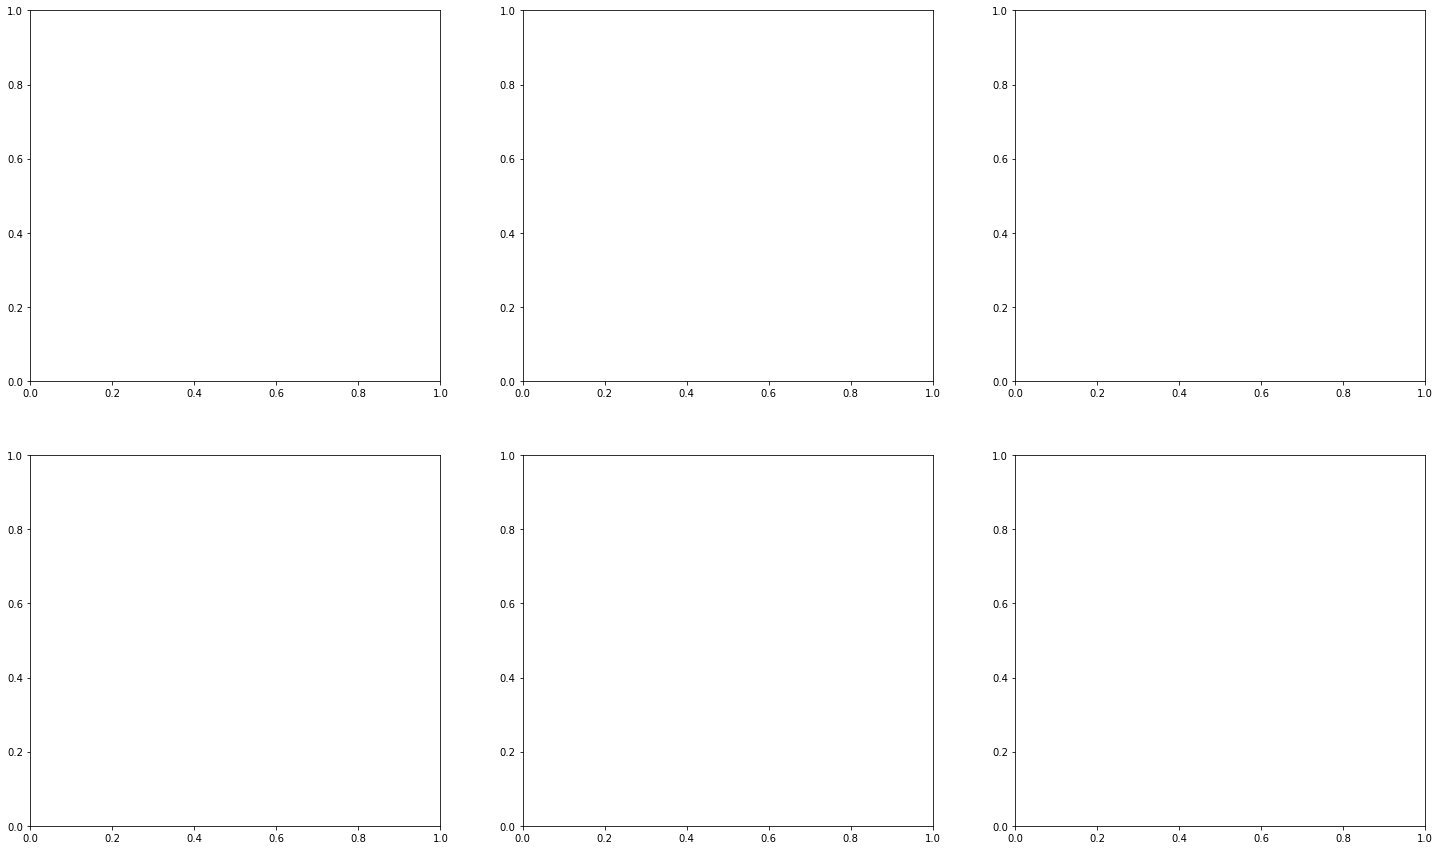

In [32]:
fig, ax = plt.subplots(2,3,figsize=(25,15))
ax = ax.ravel()
for cnt, quantile in enumerate(quantiles):
    #Renormalize and calculate forecast error
    error = mean_pinball_loss(test_dataframe["obs"].to_numpy().reshape(1,-1), target_scaler.inverse_transform(predictions[cnt]).reshape(1,-1), multioutput="raw_values", alpha=quantile)
    test_dataframe["Forecast_error"] = error
    test_dataframe["day"] = pd.DatetimeIndex(test_dataframe["obs_tm"]).dayofyear
    plot = test_dataframe.groupby("day").mean().reset_index()

    sns.regplot(x = "day", y = "Forecast_error", data=plot, ax = ax[cnt])
    ax[cnt].set_xlabel("Day of year",size = 15)
    ax[cnt].set_ylabel("Forecast error", size = 17)
    ax[cnt].set_title("Correlation for q = {}".format(quantile),size = 20)
    r = stats.pearsonr(plot["day"], plot["Forecast_error"])[0]
    rho = stats.spearmanr(plot["day"], plot["Forecast_error"])[0]
    ax[cnt].annotate('Correlation:\nr = {:.4f}\n'.format(r)+r'$\rho$ = {:.4f}'.format(rho),xy = (.01,.02), xycoords=ax[cnt].transAxes, size = 15)
    
plt.savefig("temp_time_correlation_plot.pdf", dpi=300)